<a href="https://colab.research.google.com/github/shruti1610/Weather-Forecasting/blob/master/Convolution_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.


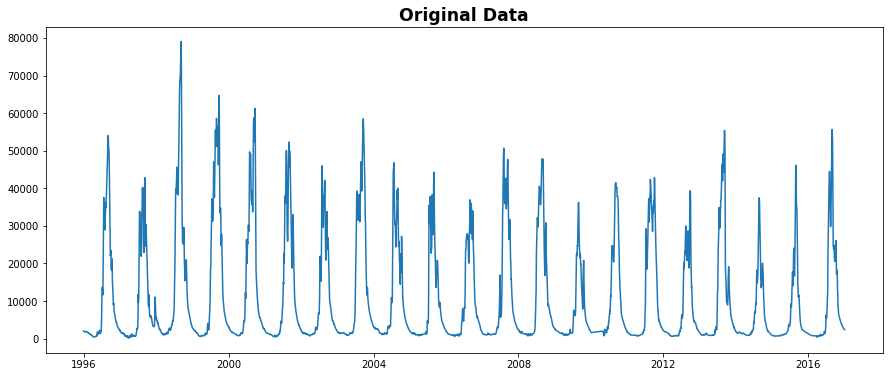

In [1]:
from numpy import array
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
import math
import numpy as np
from sklearn.metrics import mean_squared_error
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
rcParams['axes.titlesize'] = 'xx-large'
rcParams['axes.titleweight'] = 'bold'
rcParams["legend.loc"] = 'upper left'

url = 'https://raw.githubusercontent.com/shruti1610/Weather-Forecasting/master/datasets/Ganges_1996_2016.csv'
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
data = pd.read_csv(url, parse_dates=['Date'], index_col='Date',date_parser=dateparse)
data = data.astype('float32')
data.dropna(inplace = True)
plt.title("Original Data")


def dropna():
  for i in range(1,len(data)):                                             #assume first value is not absent
      if math.isnan(data['Q (m3/s)'][i]):    
        data['Q (m3/s)'][i] = data['Q (m3/s)'][i-1]
      
  data.plot()
  return data

plt.plot(data)


In [2]:
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence.iloc[i:end_ix].values, sequence.iloc[end_ix].values
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

n_steps = 20
X, y = split_sequence(data, n_steps)
#print (X)
#print(y)
print ('(samples, timesteps, features): '+ str(X.shape))
X_train, y_train = X[:-2536],y[:-2536]
X_valid, y_valid = X[-2536:-1806],y[-2536:-1806]
X_test, y_test = X[-1806:],y[-1806:]
print (X_train.shape,X_valid.shape,X_test.shape)


(samples, timesteps, features): (7567, 20, 1)
(5031, 20, 1) (730, 20, 1) (1806, 20, 1)


In [3]:
n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
# Build CNN
#Added more layers - Barkha
cnn = Sequential()
cnn.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
cnn.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
cnn.add(MaxPooling1D(pool_size=2))
cnn.add(Conv1D(filters=16, kernel_size=3, activation='relu'))
cnn.add(MaxPooling1D(pool_size=2))
cnn.add(Flatten())
cnn.add(Dense(100, activation='relu'))
cnn.add(Dense(1))
from keras import optimizers
from keras.optimizers import SGD


# All parameter gradients will be clipped to
# a maximum norm of 1.
#sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)

#model.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
cnn.compile(optimizer='Adamax', loss='mse')

cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 18, 64)            256       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 16, 32)            6176      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 8, 32)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 6, 16)             1552      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 3, 16)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 48)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)              

In [0]:
#changed verbose to zero
history= cnn.fit(X_train, y_train, batch_size = 16, validation_data = (X_valid, y_valid), epochs=50, verbose=0)

In [6]:
# make predictions
predict = cnn.predict(X_test)
# calculate root mean squared error
testScore = math.sqrt(mean_squared_error(y_test, predict))
print('Test Score: %.2f RMSE' % (testScore))

Test Score: 719.26 RMSE


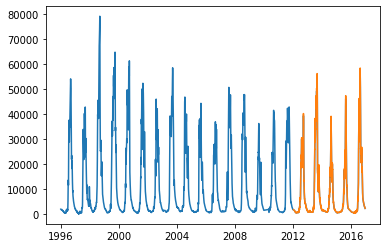

In [7]:
predict_plot = pd.DataFrame(predict,index=data.index[-1806:])
plt.plot(data)
plt.plot(predict_plot)
plt.show()